# Trablho de Conclusão de Curso - UNIVESP - 1S/2025- Notebook 4

# Código: tcc530-sala-002grupo-002

## 1.0 Packges

### Packges Import

In [1]:
# Packages

# Bibliotecas Gerais
import numpy                   as np
import pandas                  as pd
import matplotlib.pyplot       as plt
import seaborn                 as sns
from pandas import to_datetime

# Bibliotecas de Séries Temporais
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from scipy.stats import uniform
from prophet import Prophet
from mango import scheduler, Tuner

### Packges Version Control

In [2]:
pip freeze --local > ../requeriments_not4.txt

Note: you may need to restart the kernel to use updated packages.


## 2.0 Data Read

In [3]:
link   = '../dados/dados_ts.csv'
df_ts = pd.read_csv(link,sep=",",low_memory=False)

In [4]:
df_ts.head(5)

,MUNICIPIO,REGIAO,DT_NOTIFIC,Ano da notificação,Classificação final do caso
0,Mairiporã,São Paulo,2014-03-17,2014,1
1,Campinas,Campinas,2014-05-12,2014,1
2,São Paulo,São Paulo,2014-04-21,2014,1
3,São Paulo,São Paulo,2014-04-23,2014,1
4,Campinas,Campinas,2014-05-14,2014,1


## 3.0 Data Preparing

### 3.1 SP - Full

In [5]:
df_sp_full = df_ts.groupby(['DT_NOTIFIC'])['Classificação final do caso'].sum().reset_index()
df_sp_full.columns = ['ds','y']
df_sp_full['ds']= to_datetime(df_sp_full['ds'])
df_sp_full.head(5)

,ds,y
0,2013-12-29,2
1,2013-12-30,5
2,2014-01-01,3
3,2014-01-02,23
4,2014-01-03,27


## 3.2 Por Regiões - SP

In [6]:
regioes = df_ts['REGIAO'].unique()
regioes

array(['São Paulo', 'Campinas', 'São José dos Campos', 'Araçatuba',
       'São José do Rio Preto', 'Araraquara', 'Bauru', 'Marília',
       'Ribeirão Preto', 'Presidente Prudente', 'Sorocaba'], dtype=object)

In [7]:
mask = df_ts['REGIAO'] == 'São Paulo'
dftemp = df_ts[mask]
df = df_ts.groupby(['DT_NOTIFIC'])['Classificação final do caso'].sum().reset_index()
df.columns = ['Data','NN']
df.head(5)

,Data,NN
0,2013-12-29,2
1,2013-12-30,5
2,2014-01-01,3
3,2014-01-02,23
4,2014-01-03,27


## 4.0 ML Models

### 4.1 SP - Full

In [8]:
model = Prophet()
model.fit(df_sp_full)

00:41:57 - cmdstanpy - INFO - Chain [1] start processing
00:41:58 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
future = list()

for i in range(1, 13):
    dfm = 31
    if(i==2): dfm = 28
    for j in range(1,dfm):
    	date = '2024-%d-%d' % (i,j)
    	future.append([date])

for i in range(1, 13):
    dfm = 31
    if(i==2): dfm = 28
    for j in range(1,dfm):
    	date = '2025-%d-%d' % (i,j)
    	future.append([date])
        
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

          ds        yhat  yhat_lower   yhat_upper
0 2024-01-01  864.018777 -293.784265  1903.573249
1 2024-01-02  740.188250 -409.433621  1911.930949
2 2024-01-03  731.481429 -366.298186  1890.752402
3 2024-01-04  699.708708 -416.387408  1736.964526
4 2024-01-05  633.757879 -489.388705  1740.143795


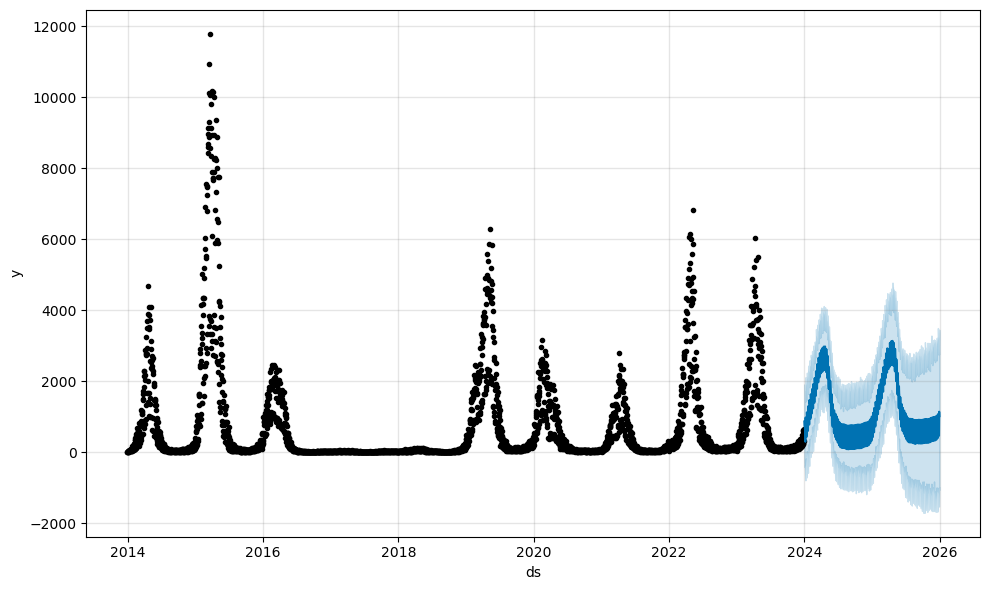

In [10]:
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
model.plot(forecast)
plt.show()

### 4.2 SP - Full - Tunning

In [11]:
param_space = dict(growth = ['linear', 'logistic', 'flat'],
                   n_changepoints  = range(0, 55, 5),
                   changepoint_range  = uniform(0.5, 0.5),
                   yearly_seasonality = [True, False],
                   weekly_seasonality = [True, False],
                   daily_seasonality = [True, False],
                   seasonality_mode = ['additive', 'multiplicative'],
                   seasonality_prior_scale=uniform(5.0, 15.0),
                   changepoint_prior_scale=uniform(0.0, 0.1),
                   interval_width = uniform(0.2, 0.8),
                   uncertainty_samples = [500, 1000, 1500, 2000]
                   )

In [12]:
days_test = 100
train = df_sp_full.drop(df_sp_full.index[-days_test:])
y_true = df_sp_full['y'][-days_test:].values
future = df_sp_full['ds'][-days_test:].values
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds'] = to_datetime(future['ds'])

In [13]:
def objective_function(args_list):
    
    params_evaluated = []
    results          = []
    
    for params in args_list:
        
        try:
        
            model = Prophet(**params)
            model.fit(train)
            forecast = model.predict(future)
            error = mape(y_true,forecast['yhat'])
            params_evaluated.append(params)
            results.append(error)
            
        except:

            params_evaluated.append(params)
            results.append(25.0)
        
    return params_evaluated, results

In [ ]:
conf_Dict = dict()
conf_Dict['initial_random'] = 10
conf_Dict['num_iteration']  = 50

tuner = Tuner(param_space, objective_function, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

00:41:58 - cmdstanpy - INFO - Chain [1] start processing
00:41:58 - cmdstanpy - INFO - Chain [1] done processing
00:41:58 - cmdstanpy - INFO - Chain [1] start processing
00:41:58 - cmdstanpy - INFO - Chain [1] done processing
00:41:59 - cmdstanpy - INFO - Chain [1] start processing
00:41:59 - cmdstanpy - INFO - Chain [1] done processing
00:41:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:41:59 - cmdstanpy - INFO - Chain [1] start processing
00:41:59 - cmdstanpy - INFO - Chain [1] done processing
00:41:59 - cmdstanpy - INFO - Chain [1] start processing
00:42:02 - cmdstanpy - INFO - Chain [1] done processing
00:42:02 - cmdstanpy - INFO - Chain [1] start processing
00:42:02 - cmdstanpy - INFO - Chain [1] done processing
00:42:03 - cmdstanpy - INFO - Chain [1] start processing
00:42:03 - cmdstanpy - INFO - Chain [1] done processing
00:42:03 - cmdstanpy - INFO - Chain [1] start process

  0%|          | 0/50 [00:00<?, ?it/s]

00:42:10 - cmdstanpy - INFO - Chain [1] start processing
00:42:10 - cmdstanpy - INFO - Chain [1] done processing
00:42:12 - cmdstanpy - INFO - Chain [1] start processing
00:42:12 - cmdstanpy - INFO - Chain [1] done processing
00:42:17 - cmdstanpy - INFO - Chain [1] start processing
00:42:17 - cmdstanpy - INFO - Chain [1] done processing
00:42:19 - cmdstanpy - INFO - Chain [1] start processing
00:42:19 - cmdstanpy - INFO - Chain [1] done processing
00:42:21 - cmdstanpy - INFO - Chain [1] start processing
00:42:21 - cmdstanpy - INFO - Chain [1] done processing
00:42:24 - cmdstanpy - INFO - Chain [1] start processing
00:42:25 - cmdstanpy - INFO - Chain [1] done processing
00:42:27 - cmdstanpy - INFO - Chain [1] start processing
00:42:27 - cmdstanpy - INFO - Chain [1] done processing
00:42:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:42:28 - cmdstanpy - INFO - Chain [1] start process